# 라이브러리

In [2]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from pandas.plotting import parallel_coordinates
import seaborn as sns
from pylab import rcParams
from collections import Counter
import tensorflow as tf
from tensorflow.keras import Model ,models, layers, optimizers, regularizers

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn import metrics

from tensorflow.keras.layers import Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, Model
from keras.layers import Input

from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau
from keras.models import load_model

import os

# 데이터 준비

In [3]:
raw_data = pd.read_csv('/content/drive/MyDrive/번천/dataset/train_data.csv')
raw_test = pd.read_csv('/content/drive/MyDrive/번천/dataset/test_data.csv')

In [4]:
raw_data.head()

,air_inflow,air_end_temp,out_pressure,motor_current,motor_rpm,motor_temp,motor_vibe,type
0,1.59,41.00,0.7,20.53,1680.0,58.67,2.93,0
1,2.97,59.28,0.7,38.40,3142.0,74.91,3.75,0
2,1.91,45.29,0.7,24.73,2023.0,62.48,3.12,0
3,2.37,51.33,0.7,30.63,2506.0,67.84,3.39,0
4,1.90,45.21,0.7,24.65,2017.0,62.41,3.12,0


In [5]:
raw_data['type'].value_counts()

0    432
1    369
2    366
3    306
4    306
5    249
6    249
7    186
Name: type, dtype: int64

In [6]:
raw_test['type'].value_counts()

0    1296
1    1107
2    1098
3     918
4     918
5     747
6     747
7     558
Name: type, dtype: int64

In [7]:
## 공기압추기가 돌아가는 순서로 열 새롭게 구성

train_data = raw_data[['air_inflow', 'motor_current','motor_rpm', 'motor_temp', 'motor_vibe', 'out_pressure', 'air_end_temp', 'type']].copy()
test_data = raw_test[['air_inflow', 'motor_current','motor_rpm', 'motor_temp', 'motor_vibe', 'out_pressure', 'air_end_temp', 'type']].copy()

설비 번호 [0, 4, 5, 6, 7]: 30HP(마력)

설비 번호 1: 20HP

설비 번호 2: 10HP

설비 번호 3: 50HP

In [8]:
hp30 = [0, 4, 5, 6, 7]
hp20 = [1]
hp10 = [2]
hp50 = [3]

In [9]:
# 설비별 데이터 세트 분리

train_data_30hp = train_data[train_data['type'].isin(hp30)].copy()
train_data_20hp = train_data[train_data['type'].isin(hp20)].copy()
train_data_10hp = train_data[train_data['type'].isin(hp10)].copy()
train_data_50hp = train_data[train_data['type'].isin(hp50)].copy()

In [10]:
# 설비별 데이터 세트 분리

test_data_30hp = test_data[test_data['type'].isin(hp30)].copy()
test_data_20hp = test_data[test_data['type'].isin(hp20)].copy()
test_data_10hp = test_data[test_data['type'].isin(hp10)].copy()
test_data_50hp = test_data[test_data['type'].isin(hp50)].copy()

# 모델 생성과 함수 설정

In [11]:
# # define the autoencoder network model
# def autoencoder_model(X):
#     inputs = Input(shape=(X.shape[1], X.shape[2]))
#     L1 = LSTM(16, activation='relu', return_sequences=True, 
#               kernel_regularizer=regularizers.l2(0.00))(inputs)
#     L2 = LSTM(4, activation='relu', return_sequences=False)(L1)
#     L3 = RepeatVector(X.shape[1])(L2)
#     L4 = LSTM(4, activation='relu', return_sequences=True)(L3)
#     L5 = LSTM(16, activation='relu', return_sequences=True)(L4)
#     output = TimeDistributed(Dense(X.shape[2]))(L5)    
#     model = Model(inputs=inputs, outputs=output)
#     return model

In [12]:
# 모델 구조
timesteps = 7
n_features = 1
layer_1 = 32
layer_2 = 16

# seed 고정
seed = 123

In [13]:
class lstm_ae(tf.keras.Model):
  def __init__(self, timesteps, n_features, layer_1, layer_2):
    super(lstm_ae).__init__()
    self.n_features = n_features
    self.timesteps = timesteps
    self.layer_1 = layer_1
    self.layer_2 = layer_2


  def encoder(self, x):
    x = layers.LSTM(self.layer_1, activation = 'tanh', return_sequences = True)(x)
    x = layers.LSTM(self.layer_2, activation = 'tanh', return_sequences = False)(x)
    en_output = layers.RepeatVector(self.timesteps)(x)
    return en_output

  def decoder(self, x):
    x = layers.LSTM(self.layer_2, activation = 'tanh', return_sequences = True)(x)
    x = layers.LSTM(self.layer_1, activation = 'tanh', return_sequences = True)(x)
    de_output = layers.TimeDistributed(layers.Dense(self.n_features))(x)

    return de_output

  def build(self):
    inputs = Input(shape = (self.timesteps, self.n_features))
    encoder = self.encoder(inputs)
    decoder = self.decoder(encoder)

    return Model(inputs, decoder)

In [14]:
# lstm 구조에 맞게 데이터 변형하는 함수

def slicing(X, lookback):
    output_X = []
    # output_y = []
    for i in range(len(X) - lookback +1):
        t = []
        for j in range(0, lookback):
            t.append(X[(i + j), :])
        output_X.append(t)
    return np.array(output_X)

In [15]:
## 평행 좌표 그리는 함수

def parallel(for_view, num):
  parallel_coordinates(frame = for_view[for_view['type'].isin(num)], class_column = 'type', colormap = plt.get_cmap('Set1'));

In [16]:
## 모델 평가를 위해 3차원을 2차원으로 줄임

def flatten(X):
    flattened_X = X.reshape(X.shape[0], -1)
    return flattened_X

In [17]:
## timestep 3 이기 때문에 처음 두 개의 데이터에 대한 가정

def plus(anom):
  if anom[0] == 0:
    return [0,0] + list(anom*1)
  else:
    return [0,1] + list(anom*1)

# 경로 설정

In [18]:
# 현재 폴더 경로 지정
PATH = '/content/drive/MyDrive/번천/모델5'
os.chdir(PATH)
os.getcwd()

'/content/drive/MyDrive/번천/모델5'

# hp30

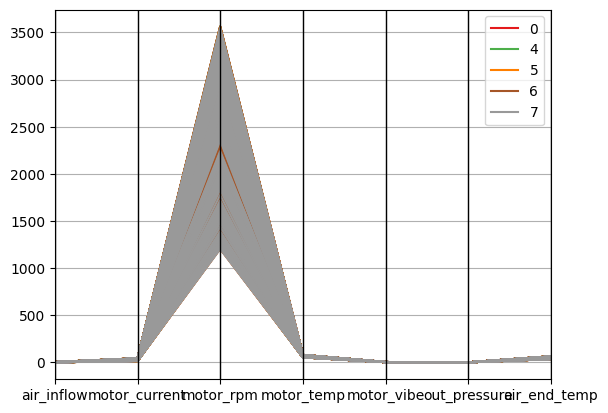

In [ ]:
parallel(train_data, hp30)

In [19]:
## 모델 학습을 위해 데이터 준비

scaler_30hp = StandardScaler()

# 설비 라벨 제외하여 train data로 정규화
train_scale_30hp = scaler_30hp.fit_transform(train_data_30hp.drop(['type'], axis=1))
test_scale_30hp = scaler_30hp.transform(test_data_30hp.drop(['type'], axis=1))

# LTSM 구조에 맞게 데이터 변형
test_slice_30hp = slicing(test_scale_30hp,1).reshape(-1, 7 ,1)
train_slice_30hp = slicing(train_scale_30hp,1).reshape(-1, 7 ,1)


# train / validation 구분
X_train, X_test = train_test_split(train_slice_30hp, test_size=0.1, random_state=seed)

In [ ]:
## 모델 학습

lstm_ae_30hp = lstm_ae(timesteps, n_features, layer_1, layer_2).build()

lstm_ae_30hp.compile(optimizer = 'adam', loss = 'mse')

# lr 계획과 모델 저장 코드
reduceLR = ReduceLROnPlateau(monitor='val_loss',
                             factor=.5,
                             patience=20,
                             verbose=1,
                             mode = 'min'
                             )
modelCheckpoint = ModelCheckpoint(filepath='./모델 저장/30hp.h5',
                                                  monitor='val_loss',
                                                  save_best_only=True,
                                                  verbose = 1)
callbacks_list = [reduceLR, modelCheckpoint]

# 모델 학습
history = lstm_ae_30hp.fit(X_train, X_train,
                           epochs=200, batch_size=32,
                           validation_data=(X_test, X_test),
                           callbacks=callbacks_list)

# history 저장
np.save('./30hp_history.npy',history.history)

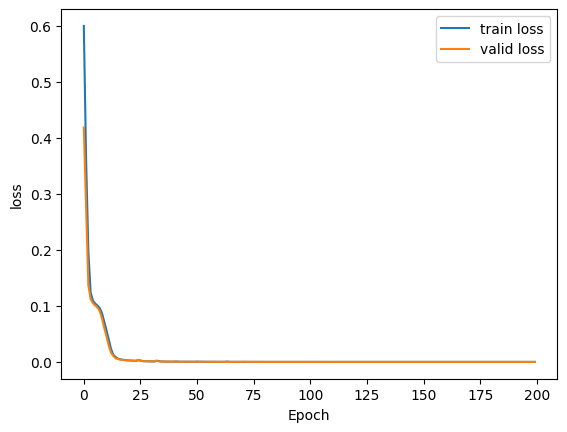

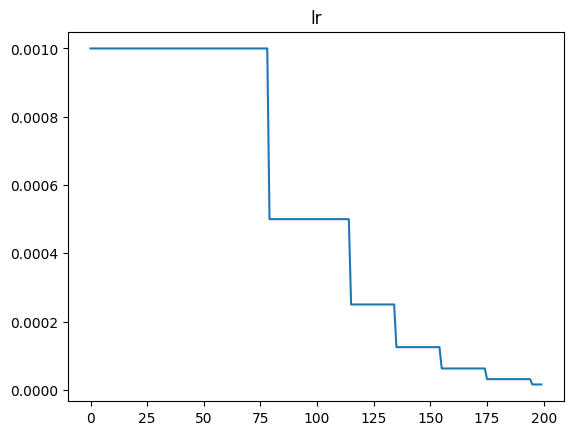

In [21]:
# 저장한 model과 history 불러오기
lstm_ae_30hp = load_model('./모델 저장/30hp.h5')
history = history=np.load('./30hp_history.npy',allow_pickle='TRUE').item()


# loss 그리기
plt.plot(history['loss'], label='train loss')
plt.plot(history['val_loss'], label='valid loss')
plt.legend()
plt.xlabel('Epoch'); plt.ylabel('loss')
plt.show()

# lr 변화 그리기
plt.title('lr')
plt.plot(history['lr'], label='train')
plt.show()

In [22]:
# 역치 계산
pred_train_30hp = lstm_ae_30hp.predict(train_slice_30hp)
train_mse_30hp = np.mean(np.square(flatten(train_slice_30hp) - flatten(pred_train_30hp)), axis =1 )
threshold_30hp = np.max(train_mse_30hp)

# 계산한 역치로 이상 판단
pred_test_30hp = lstm_ae_30hp.predict(test_slice_30hp)
test_mse_30hp = np.mean(np.square(flatten(test_slice_30hp) - flatten(pred_test_30hp)), axis =1 )
anom_30hp = test_mse_30hp > threshold_30hp

# pred 데이터 생성
pred_30hp = test_data_30hp.copy()
pred_30hp['y'] = anom_30hp

# 개수 확인
print(np.sum(anom_30hp))

134/134 [==============================] - 0s 3ms/step
291


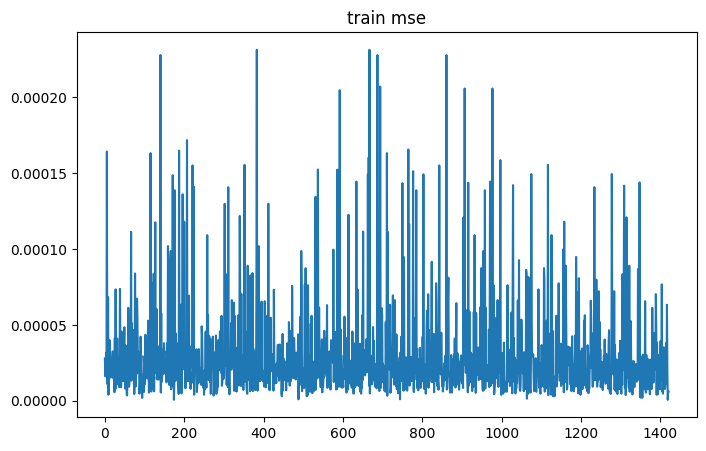

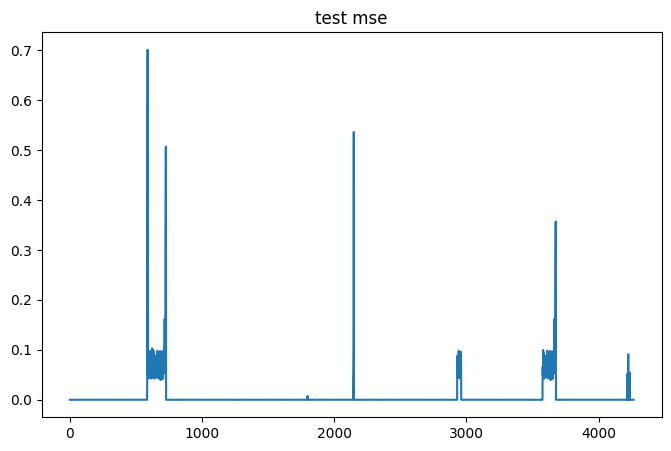

In [65]:
# train mse 그리기
plt.figure(figsize = (8,5));
plt.plot(train_mse_30hp);
plt.title('train mse');

# test mse 그리기
plt.figure(figsize = (8,5));
plt.plot(test_mse_30hp);
plt.title('test mse');

# hp20

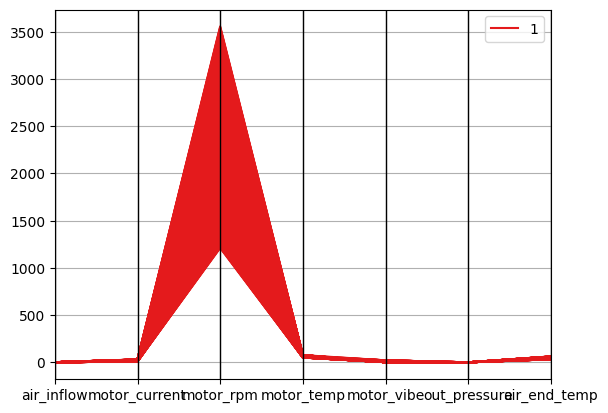

In [ ]:
parallel(train_data, hp20)

이전 모델에서 train의 126 ~ 164 까지의 데이터는 이상 데이터로 판단

In [ ]:
# first = 126
# last = 164

# new_train_20hp = pd.concat([train_data_20hp.iloc[:first], train_data_20hp.iloc[last + 1:]])

In [24]:
## 모델 학습을 위해 데이터 준비

scaler_20hp = StandardScaler()

# 설비 라벨 제외하여 train data로 정규화
train_scale_20hp = scaler_20hp.fit_transform(train_data_20hp.drop(['type'], axis=1))
test_scale_20hp = scaler_20hp.transform(test_data_20hp.drop(['type'], axis=1))

# LTSM 구조에 맞게 데이터 변형
test_slice_20hp = slicing(test_scale_20hp,1).reshape(-1, 7 ,1)
train_slice_20hp = slicing(train_scale_20hp,1).reshape(-1, 7 ,1)


# train / validation 구분
X_train, X_test = train_test_split(train_slice_20hp, test_size=0.1, random_state=seed)

In [25]:
## 모델 학습

lstm_ae_20hp = lstm_ae(timesteps, n_features, layer_1, layer_2).build()

lstm_ae_20hp.compile(optimizer = 'adam', loss = 'mse')

# lr 계획과 모델 저장 코드
reduceLR = ReduceLROnPlateau(monitor='val_loss',
                             factor=.5,
                             patience=20,
                             verbose=1,
                             mode = 'min'
                             )
modelCheckpoint = ModelCheckpoint(filepath='./모델 저장/20hp.h5',
                                                  monitor='val_loss',
                                                  save_best_only=True,
                                                  verbose = 1)
callbacks_list = [reduceLR, modelCheckpoint]

# 모델 학습
history = lstm_ae_20hp.fit(X_train, X_train,
                           epochs=200, batch_size=32,
                           validation_data=(X_test, X_test),
                           callbacks=callbacks_list)

# history 저장
np.save('./20hp_history.npy',history.history)

Epoch 1/200
 7/11 [==================>...........] - ETA: 0s - loss: 0.8252  
Epoch 1: val_loss improved from inf to 0.98945, saving model to ./모델 저장/20hp.h5
11/11 [==============================] - 12s 171ms/step - loss: 0.8343 - val_loss: 0.9895 - lr: 0.0010
Epoch 2/200
 8/11 [====================>.........] - ETA: 0s - loss: 0.8320
Epoch 2: val_loss improved from 0.98945 to 0.90604, saving model to ./모델 저장/20hp.h5
11/11 [==============================] - 0s 18ms/step - loss: 0.7885 - val_loss: 0.9060 - lr: 0.0010
Epoch 3/200
 7/11 [==================>...........] - ETA: 0s - loss: 0.6500
Epoch 3: val_loss improved from 0.90604 to 0.75313, saving model to ./모델 저장/20hp.h5
11/11 [==============================] - 0s 18ms/step - loss: 0.6580 - val_loss: 0.7531 - lr: 0.0010
Epoch 4/200
 8/11 [====================>.........] - ETA: 0s - loss: 0.5596
Epoch 4: val_loss improved from 0.75313 to 0.74084, saving model to ./모델 저장/20hp.h5
11/11 [==========================

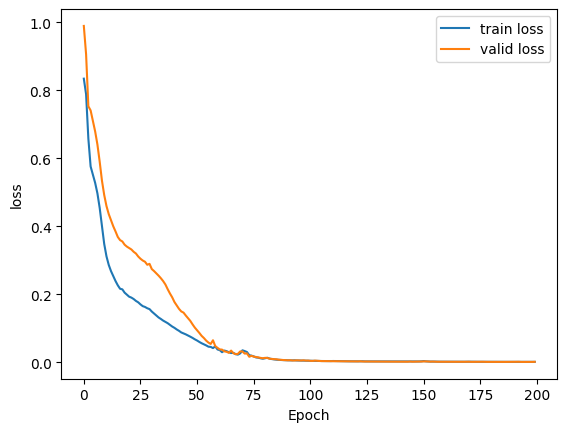

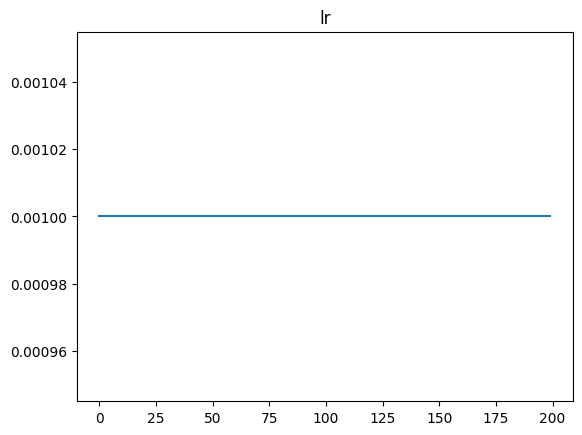

In [26]:
# 저장한 model과 history 불러오기
lstm_ae_20hp = load_model('./모델 저장/20hp.h5')
history = history=np.load('./20hp_history.npy',allow_pickle='TRUE').item()


# loss 그리기
plt.plot(history['loss'], label='train loss')
plt.plot(history['val_loss'], label='valid loss')
plt.legend()
plt.xlabel('Epoch'); plt.ylabel('loss')
plt.show()

# lr 변화 그리기
plt.title('lr')
plt.plot(history['lr'], label='train')
plt.show()

In [27]:
# 역치 계산
pred_train_20hp = lstm_ae_20hp.predict(train_slice_20hp)
train_mse_20hp = np.mean(np.square(flatten(train_slice_20hp) - flatten(pred_train_20hp)), axis =1 )
threshold_20hp = np.max(train_mse_20hp)

# 계산한 역치로 이상 판단
pred_test_20hp = lstm_ae_20hp.predict(test_slice_20hp)
test_mse_20hp = np.mean(np.square(flatten(test_slice_20hp) - flatten(pred_test_20hp)), axis =1 )
anom_20hp = test_mse_20hp > threshold_20hp

# pred 데이터 생성
pred_20hp = test_data_20hp.copy()
pred_20hp['y'] = anom_20hp

# 개수 확인
print(np.sum(anom_20hp))

35/35 [==============================] - 0s 3ms/step
0


In [43]:
np.mean(train_mse_20hp)

0.0010537261217758672

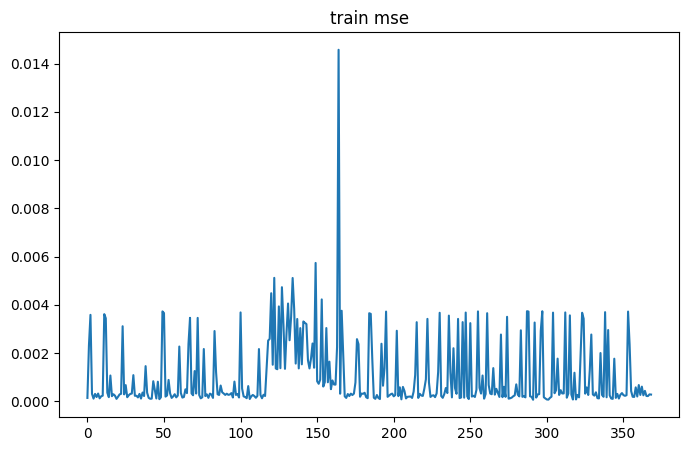

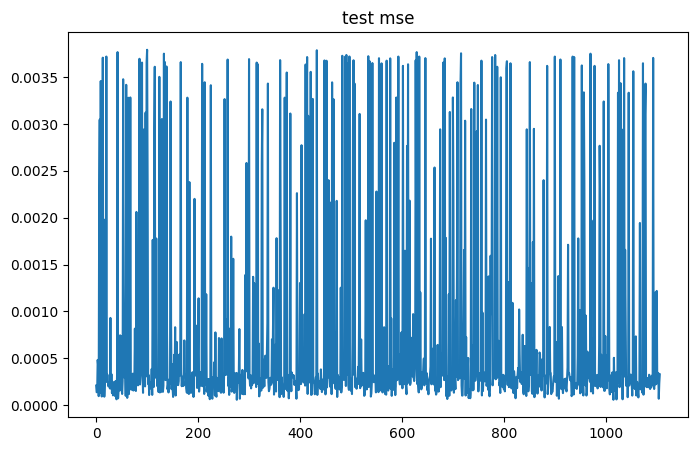

In [28]:
# train mse 그리기
plt.figure(figsize = (8,5));
plt.plot(train_mse_20hp);
plt.title('train mse');

# test mse 그리기
plt.figure(figsize = (8,5));
plt.plot(test_mse_20hp);
plt.title('test mse');

맞지 않은 데이터 제거 필요

# hp10


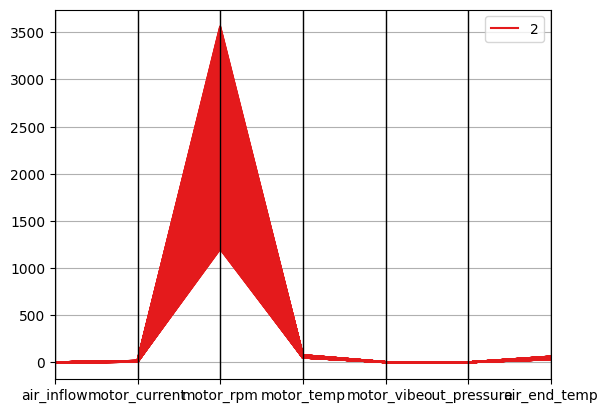

In [ ]:
parallel(train_data, hp10)

In [29]:
## 모델 학습을 위해 데이터 준비

scaler_10hp = StandardScaler()

# 설비 라벨 제외하여 train data로 정규화
train_scale_10hp = scaler_10hp.fit_transform(train_data_10hp.drop(['type'], axis=1))
test_scale_10hp = scaler_10hp.transform(test_data_10hp.drop(['type'], axis=1))

# LTSM 구조에 맞게 데이터 변형
test_slice_10hp = slicing(test_scale_10hp,1).reshape(-1, 7 ,1)
train_slice_10hp = slicing(train_scale_10hp,1).reshape(-1, 7 ,1)


# train / validation 구분
X_train, X_test = train_test_split(train_slice_10hp, test_size=0.1, random_state=seed)

In [30]:
## 모델 학습

lstm_ae_10hp = lstm_ae(timesteps, n_features, layer_1, layer_2).build()

lstm_ae_10hp.compile(optimizer = 'adam', loss = 'mse')

# lr 계획과 모델 저장 코드
reduceLR = ReduceLROnPlateau(monitor='val_loss',
                             factor=.5,
                             patience=20,
                             verbose=1,
                             mode = 'min'
                             )
modelCheckpoint = ModelCheckpoint(filepath='./모델 저장/10hp.h5',
                                                  monitor='val_loss',
                                                  save_best_only=True,
                                                  verbose = 1)
callbacks_list = [reduceLR, modelCheckpoint]

# 모델 학습
history = lstm_ae_10hp.fit(X_train, X_train,
                           epochs=200, batch_size=32,
                           validation_data=(X_test, X_test),
                           callbacks=callbacks_list)

# history 저장
np.save('./10hp_history.npy',history.history)

Epoch 1/200
10/11 [==========================>...] - ETA: 0s - loss: 0.8061
Epoch 1: val_loss improved from inf to 0.85496, saving model to ./모델 저장/10hp.h5
11/11 [==============================] - 10s 201ms/step - loss: 0.8096 - val_loss: 0.8550 - lr: 0.0010
Epoch 2/200
 6/11 [===============>..............] - ETA: 0s - loss: 0.7483
Epoch 2: val_loss improved from 0.85496 to 0.62174, saving model to ./모델 저장/10hp.h5
11/11 [==============================] - 0s 20ms/step - loss: 0.6733 - val_loss: 0.6217 - lr: 0.0010
Epoch 3/200
 7/11 [==================>...........] - ETA: 0s - loss: 0.4686
Epoch 3: val_loss improved from 0.62174 to 0.48665, saving model to ./모델 저장/10hp.h5
11/11 [==============================] - 0s 17ms/step - loss: 0.4718 - val_loss: 0.4867 - lr: 0.0010
Epoch 4/200
 8/11 [====================>.........] - ETA: 0s - loss: 0.4386
Epoch 4: val_loss improved from 0.48665 to 0.45362, saving model to ./모델 저장/10hp.h5
11/11 [============================

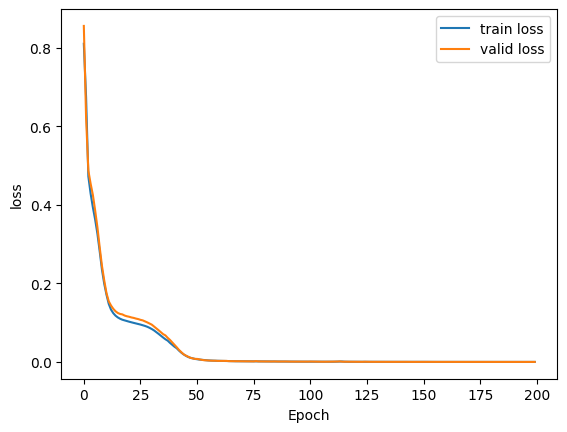

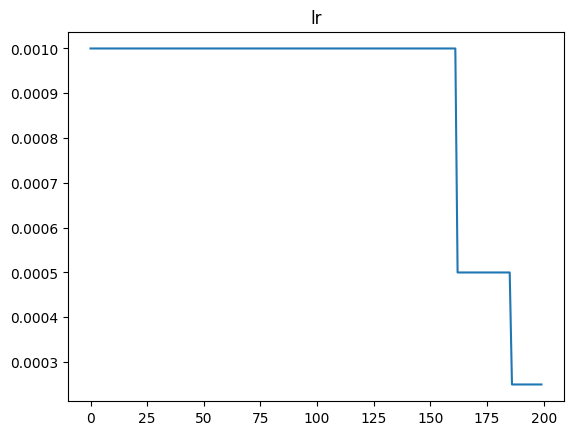

In [31]:
# 저장한 model과 history 불러오기
lstm_ae_10hp = load_model('./모델 저장/10hp.h5')
history = history=np.load('./10hp_history.npy',allow_pickle='TRUE').item()


# loss 그리기
plt.plot(history['loss'], label='train loss')
plt.plot(history['val_loss'], label='valid loss')
plt.legend()
plt.xlabel('Epoch'); plt.ylabel('loss')
plt.show()

# lr 변화 그리기
plt.title('lr')
plt.plot(history['lr'], label='train')
plt.show()

In [32]:
# 역치 계산
pred_train_10hp = lstm_ae_10hp.predict(train_slice_10hp)
train_mse_10hp = np.mean(np.square(flatten(train_slice_10hp) - flatten(pred_train_10hp)), axis =1 )
threshold_10hp = np.max(train_mse_10hp)

# 계산한 역치로 이상 판단
pred_test_10hp = lstm_ae_10hp.predict(test_slice_10hp)
test_mse_10hp = np.mean(np.square(flatten(test_slice_10hp) - flatten(pred_test_10hp)), axis =1 )
anom_10hp = test_mse_10hp > threshold_10hp

# pred 데이터 생성
pred_10hp = test_data_10hp.copy()
pred_10hp['y'] = anom_10hp

# 개수 확인
print(np.sum(anom_10hp))

35/35 [==============================] - 0s 3ms/step
29


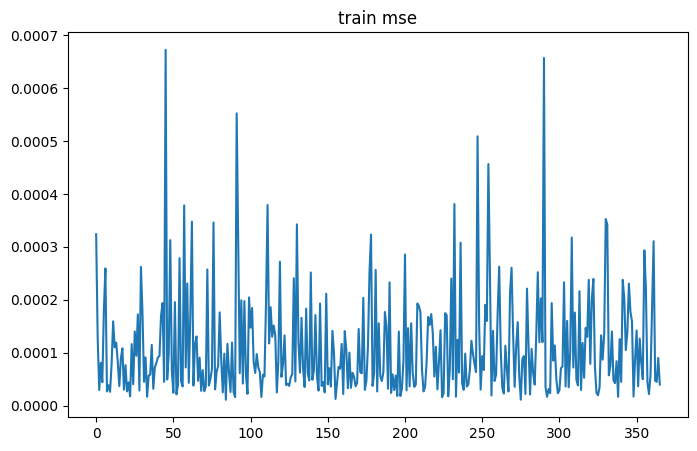

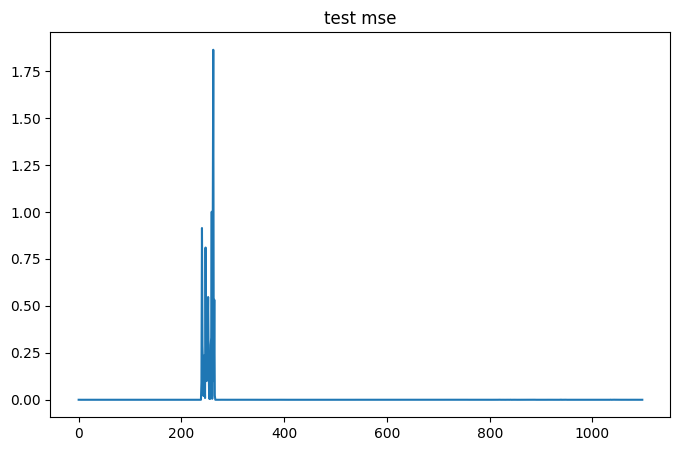

In [33]:
# train mse 그리기
plt.figure(figsize = (8,5));
plt.plot(train_mse_10hp);
plt.title('train mse');

# test mse 그리기
plt.figure(figsize = (8,5));
plt.plot(test_mse_10hp);
plt.title('test mse');

# hp50

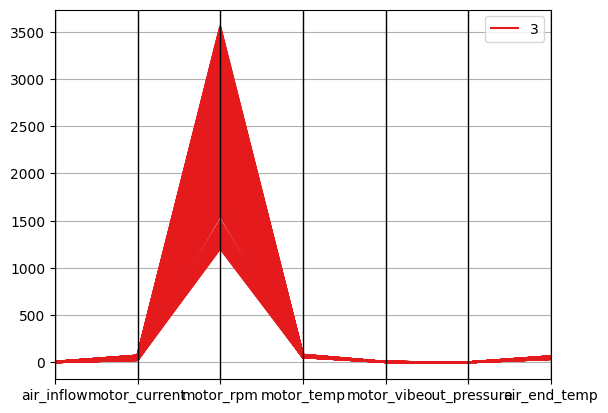

In [ ]:
parallel(train_data, hp50)

In [34]:
## 모델 학습을 위해 데이터 준비

scaler_50hp = StandardScaler()

# 설비 라벨 제외하여 train data로 정규화
train_scale_50hp = scaler_50hp.fit_transform(train_data_50hp.drop(['type'], axis=1))
test_scale_50hp = scaler_50hp.transform(test_data_50hp.drop(['type'], axis=1))

# LTSM 구조에 맞게 데이터 변형
test_slice_50hp = slicing(test_scale_50hp,1).reshape(-1, 7 ,1)
train_slice_50hp = slicing(train_scale_50hp,1).reshape(-1, 7 ,1)


# train / validation 구분
X_train, X_test = train_test_split(train_slice_50hp, test_size=0.1, random_state=seed)

In [35]:
## 모델 학습

lstm_ae_50hp = lstm_ae(timesteps, n_features, layer_1, layer_2).build()

lstm_ae_50hp.compile(optimizer = 'adam', loss = 'mse')

# lr 계획과 모델 저장 코드
reduceLR = ReduceLROnPlateau(monitor='val_loss',
                             factor=.5,
                             patience=20,
                             verbose=1,
                             mode = 'min'
                             )
modelCheckpoint = ModelCheckpoint(filepath='./모델 저장/50hp.h5',
                                                  monitor='val_loss',
                                                  save_best_only=True,
                                                  verbose = 1)
callbacks_list = [reduceLR, modelCheckpoint]

# 모델 학습
history = lstm_ae_50hp.fit(X_train, X_train,
                           epochs=200, batch_size=32,
                           validation_data=(X_test, X_test),
                           callbacks=callbacks_list)

# history 저장
np.save('./50hp_history.npy',history.history)

Epoch 1/200
7/9 [======================>.......] - ETA: 0s - loss: 0.8013 
Epoch 1: val_loss improved from inf to 0.92245, saving model to ./모델 저장/50hp.h5
9/9 [==============================] - 9s 247ms/step - loss: 0.8177 - val_loss: 0.9225 - lr: 0.0010
Epoch 2/200
8/9 [=========================>....] - ETA: 0s - loss: 0.7345
Epoch 2: val_loss improved from 0.92245 to 0.78823, saving model to ./모델 저장/50hp.h5
9/9 [==============================] - 0s 21ms/step - loss: 0.7353 - val_loss: 0.7882 - lr: 0.0010
Epoch 3/200
8/9 [=========================>....] - ETA: 0s - loss: 0.5857
Epoch 3: val_loss improved from 0.78823 to 0.57708, saving model to ./모델 저장/50hp.h5
9/9 [==============================] - 0s 21ms/step - loss: 0.5715 - val_loss: 0.5771 - lr: 0.0010
Epoch 4/200
6/9 [===================>..........] - ETA: 0s - loss: 0.4670
Epoch 4: val_loss improved from 0.57708 to 0.49424, saving model to ./모델 저장/50hp.h5
9/9 [==============================] - 0s 23ms/st

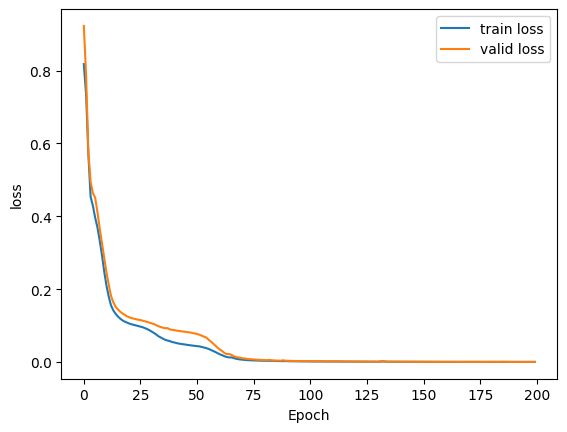

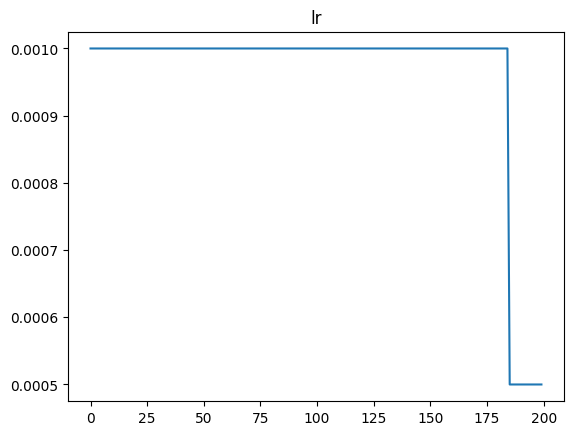

In [36]:
# 저장한 model과 history 불러오기
lstm_ae_50hp = load_model('./모델 저장/50hp.h5')
history = history=np.load('./50hp_history.npy',allow_pickle='TRUE').item()


# loss 그리기
plt.plot(history['loss'], label='train loss')
plt.plot(history['val_loss'], label='valid loss')
plt.legend()
plt.xlabel('Epoch'); plt.ylabel('loss')
plt.show()

# lr 변화 그리기
plt.title('lr')
plt.plot(history['lr'], label='train')
plt.show()

In [37]:
# 역치 계산
pred_train_50hp = lstm_ae_50hp.predict(train_slice_50hp)
train_mse_50hp = np.mean(np.square(flatten(train_slice_50hp) - flatten(pred_train_50hp)), axis =1 )
threshold_50hp = np.max(train_mse_50hp)

# 계산한 역치로 이상 판단
pred_test_50hp = lstm_ae_50hp.predict(test_slice_50hp)
test_mse_50hp = np.mean(np.square(flatten(test_slice_50hp) - flatten(pred_test_50hp)), axis =1 )
anom_50hp = test_mse_50hp > threshold_50hp

# pred 데이터 생성
pred_50hp = test_data_50hp.copy()
pred_50hp['y'] = anom_50hp

# 개수 확인
print(np.sum(anom_50hp))

29/29 [==============================] - 0s 3ms/step
32


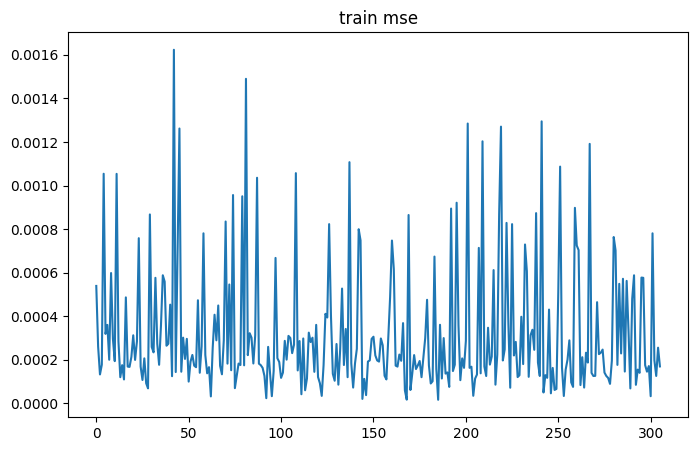

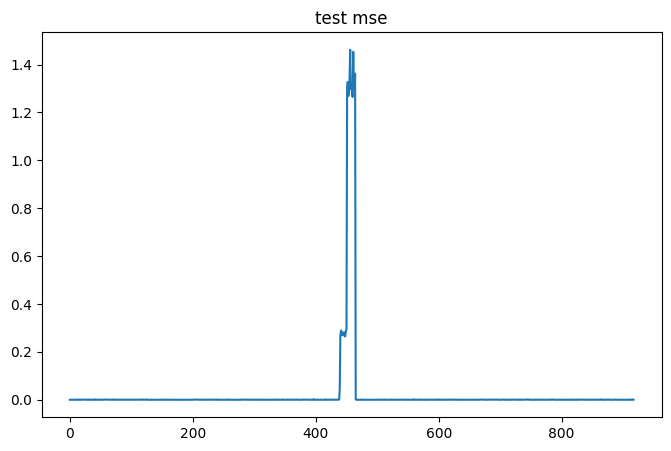

In [38]:
# train mse 그리기
plt.figure(figsize = (8,5));
plt.plot(train_mse_50hp);
plt.title('train mse');

# test mse 그리기
plt.figure(figsize = (8,5));
plt.plot(test_mse_50hp);
plt.title('test mse');

# pred 합치기

test_data_30hp

test_data_20hp

test_data_10hp

test_data_50hp

In [39]:
answer = pd.concat([pred_30hp['y'], pred_20hp['y'], pred_10hp['y'], pred_50hp['y']]).sort_index()
answer = pd.concat([test_data['type'], answer], axis=1)
answer.rename(columns={'y':'label'}, inplace = True)

In [40]:
answer

,type,label
0,0,False
1,0,False
2,0,False
3,0,False
4,0,False
...,...,...
7384,7,False
7385,7,False
7386,7,False
7387,7,False


In [41]:
answer.to_csv("/content/drive/MyDrive/번천/answer/answer_model11.csv")